# Gaussian Process Regression

Given the time-series of the slope $b$ for the cloud size distribution $\mathcal{C}$ we can use Gaussian Process (GP) regression to estimate the period of oscillation. In this notebook, we use the time-series $b(t)$ obtained in the previous notebook and present the numerical methods used to process the noisy time-series from high-resolution LES model output.

In [1]:
import numpy as np
import pandas as pd

import sklearn.preprocessing as skl_prep
from statsmodels.nonparametric import smoothers_lowess as sl

# Pytorch + GP
import torch, gpytorch

from pathlib import Path
from rich import print
from tqdm import tqdm

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks', 
    {
        'axes.grid': True, 
        'axes.linewidth': '1',
        'grid.color': '0.5',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })
xkcd = sns.xkcd_rgb


rc_opt = {
    "figure.dpi": 300,
    "font.family": "serif",
    "font.size": 15,
    "text.usetex": False,
    'text.latex.preamble': r"\usepackage{libertine} \usepackage[libertine]{newtxmath}",
}
mpl.rcParams.update(rc_opt)

cp = sns.color_palette()

In [3]:
# CUDA setup
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

if device.type == 'cuda':
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    print(f"Using {device}")

Using NVIDIA GeForce RTX 3090

The following code loads the stored time-series $b(t)$ and makes a plot.

In [4]:
p = Path('../pq/slope_CGILS_S6_CLD_KDE_PIECEWISE.pq')
df = pd.read_parquet(p)

In [5]:
y = df.slope.to_numpy()[:720]
x = np.arange(len(y))

x_full = torch.tensor(x, dtype=torch.double)
y_full = torch.tensor(y, dtype=torch.double)

x_tr = torch.tensor(x, dtype=torch.double)
y_tr = torch.tensor(y, dtype=torch.double)

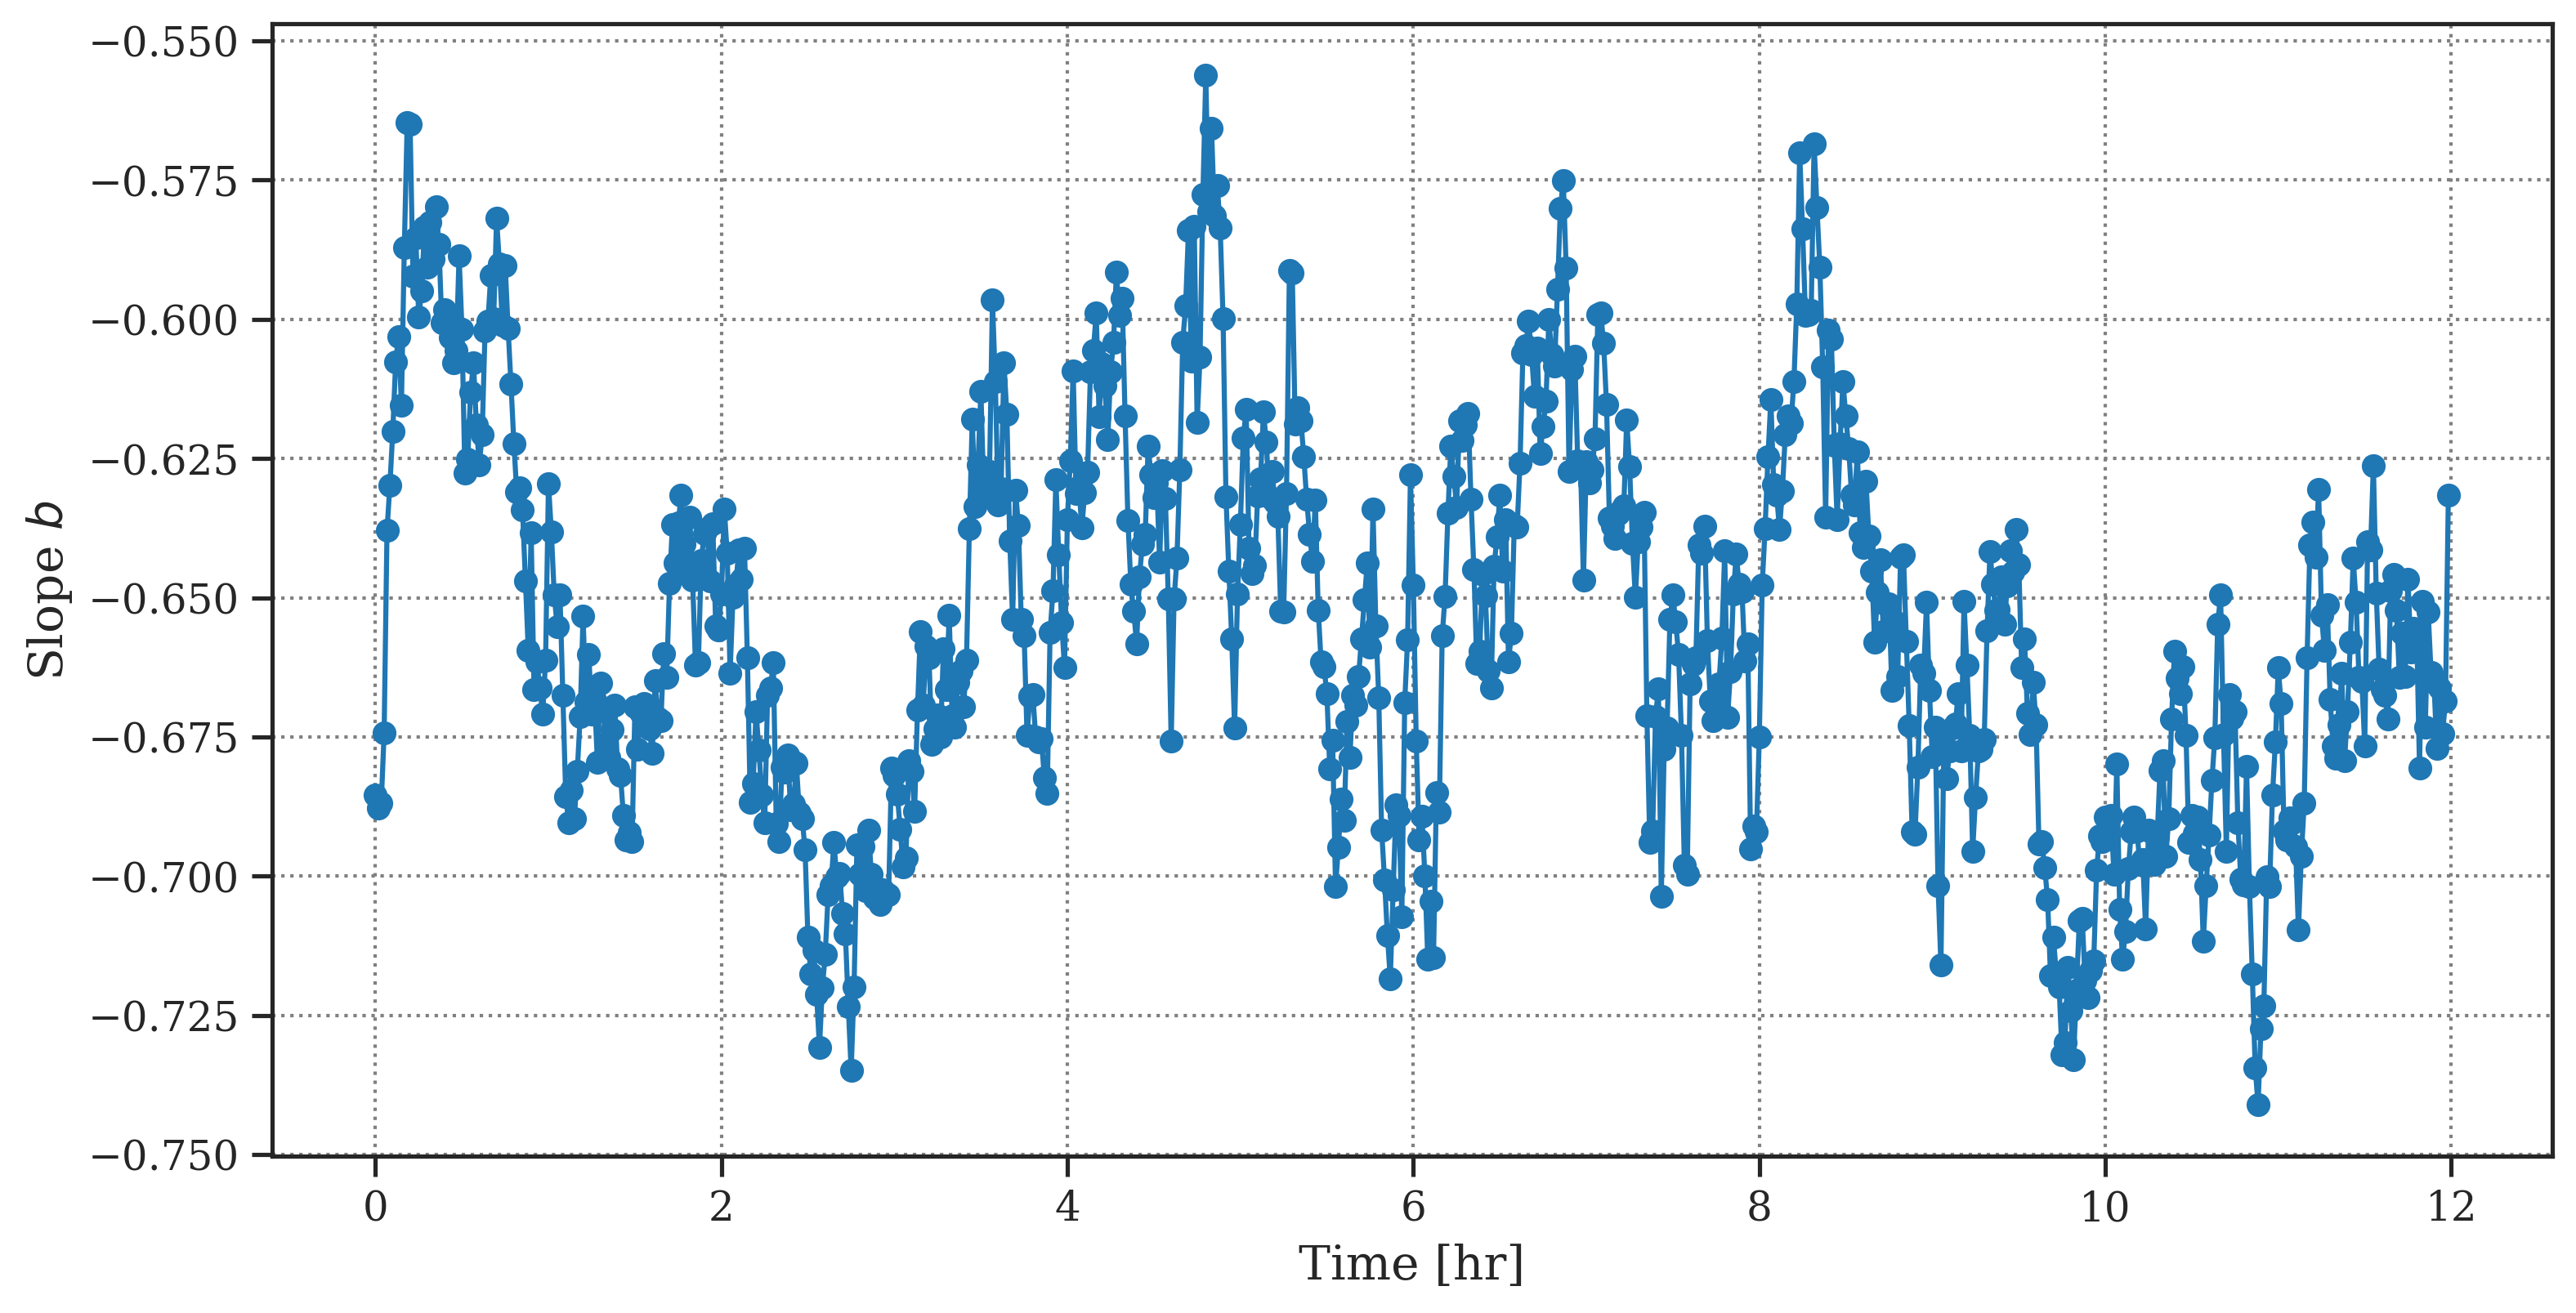

In [6]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6), dpi=300)
ax.plot(x_full / 60, y_full, 'o-')

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

Based on the literature, our hypothesis is that there is an underlying oscillation in this time-series $b(t)$. A quick look at the plot above shows that there are definitely some variability in the time-series, but it is not clear if those changes occur at regular intervals because of the noise in the estimation of the slope $b$ of the cloud size distribution $\mathcal{C}$.

The numerical method used for the periodicity detection can be taken in two steps. First, we will smooth out the time-series using GP regressor. This is not strictly necessary, but it makes the actual periodicity detection much easier (and reduces the uncertainty involved). Second, we define another GP model with a periodic kernel to identify the underlying periodic component.

Let's define our GP model. To account for the variability in the observed time-series, we use a custom kernel

$$ k = k_{\mathrm{SE}} + k_{\mathrm{Per}}$$

which combined the squared exponential (SE) and periodic kernels.

The main purpose of the periodic kernel here is to obtain an estimate of the underlying oscillatory motion. The SE kernel ensures that we model the underlying (smooth) distribution, and the periodic kernel provides a quick estimate of the periodicity that will be used for the actual periodicity estimate.

In [7]:
if device.type == 'cuda':
    x_tr = x_tr.to(device)
    y_tr = y_tr.to(device)

In [8]:
class SmoothGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(SmoothGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.cov_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()),
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)
        
        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov)

In [9]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.GreaterThan(1.e-2),
    noise_prior = gpytorch.priors.NormalPrior(1.e-2, 1)
)
model = SmoothGPModel(x_tr, y_tr, likelihood)

# Initialize kernels
model.cov_module.kernels[0].base_kernel.initialize(
    lengthscale = torch.tensor(30.)
)

model.cov_module.kernels[1].base_kernel.initialize(
    lengthscale = torch.tensor(30.),
    period_length = torch.tensor(90.),
)

model.double()

SmoothGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-02)
    )
  )
  (mean_module): ConstantMean()
  (cov_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): ScaleKernel(
        (base_kernel): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
    )
  )
)

In [10]:
# Find optimal model hyperparameters
if device.type == 'cuda':
    model = model.to(device)
    likelihood = likelihood.to(device)
    
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=1e-1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 200
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

200/200 Loss: -1.319: 100%|██████████| 200/200 [00:02<00:00, 79.57it/s]


In [11]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name} {param.item()}")

likelihood.noise_covar.raw_noise -8.134797066425433

mean_module.raw_constant -0.6549045145681404

cov_module.kernels.0.raw_outputscale -7.650724526420033

cov_module.kernels.0.base_kernel.raw_lengthscale 36.998600893431465

cov_module.kernels.1.raw_outputscale -6.496113827263108

cov_module.kernels.1.base_kernel.raw_lengthscale 22.99585299312994

cov_module.kernels.1.base_kernel.raw_period_length 95.44535117542316

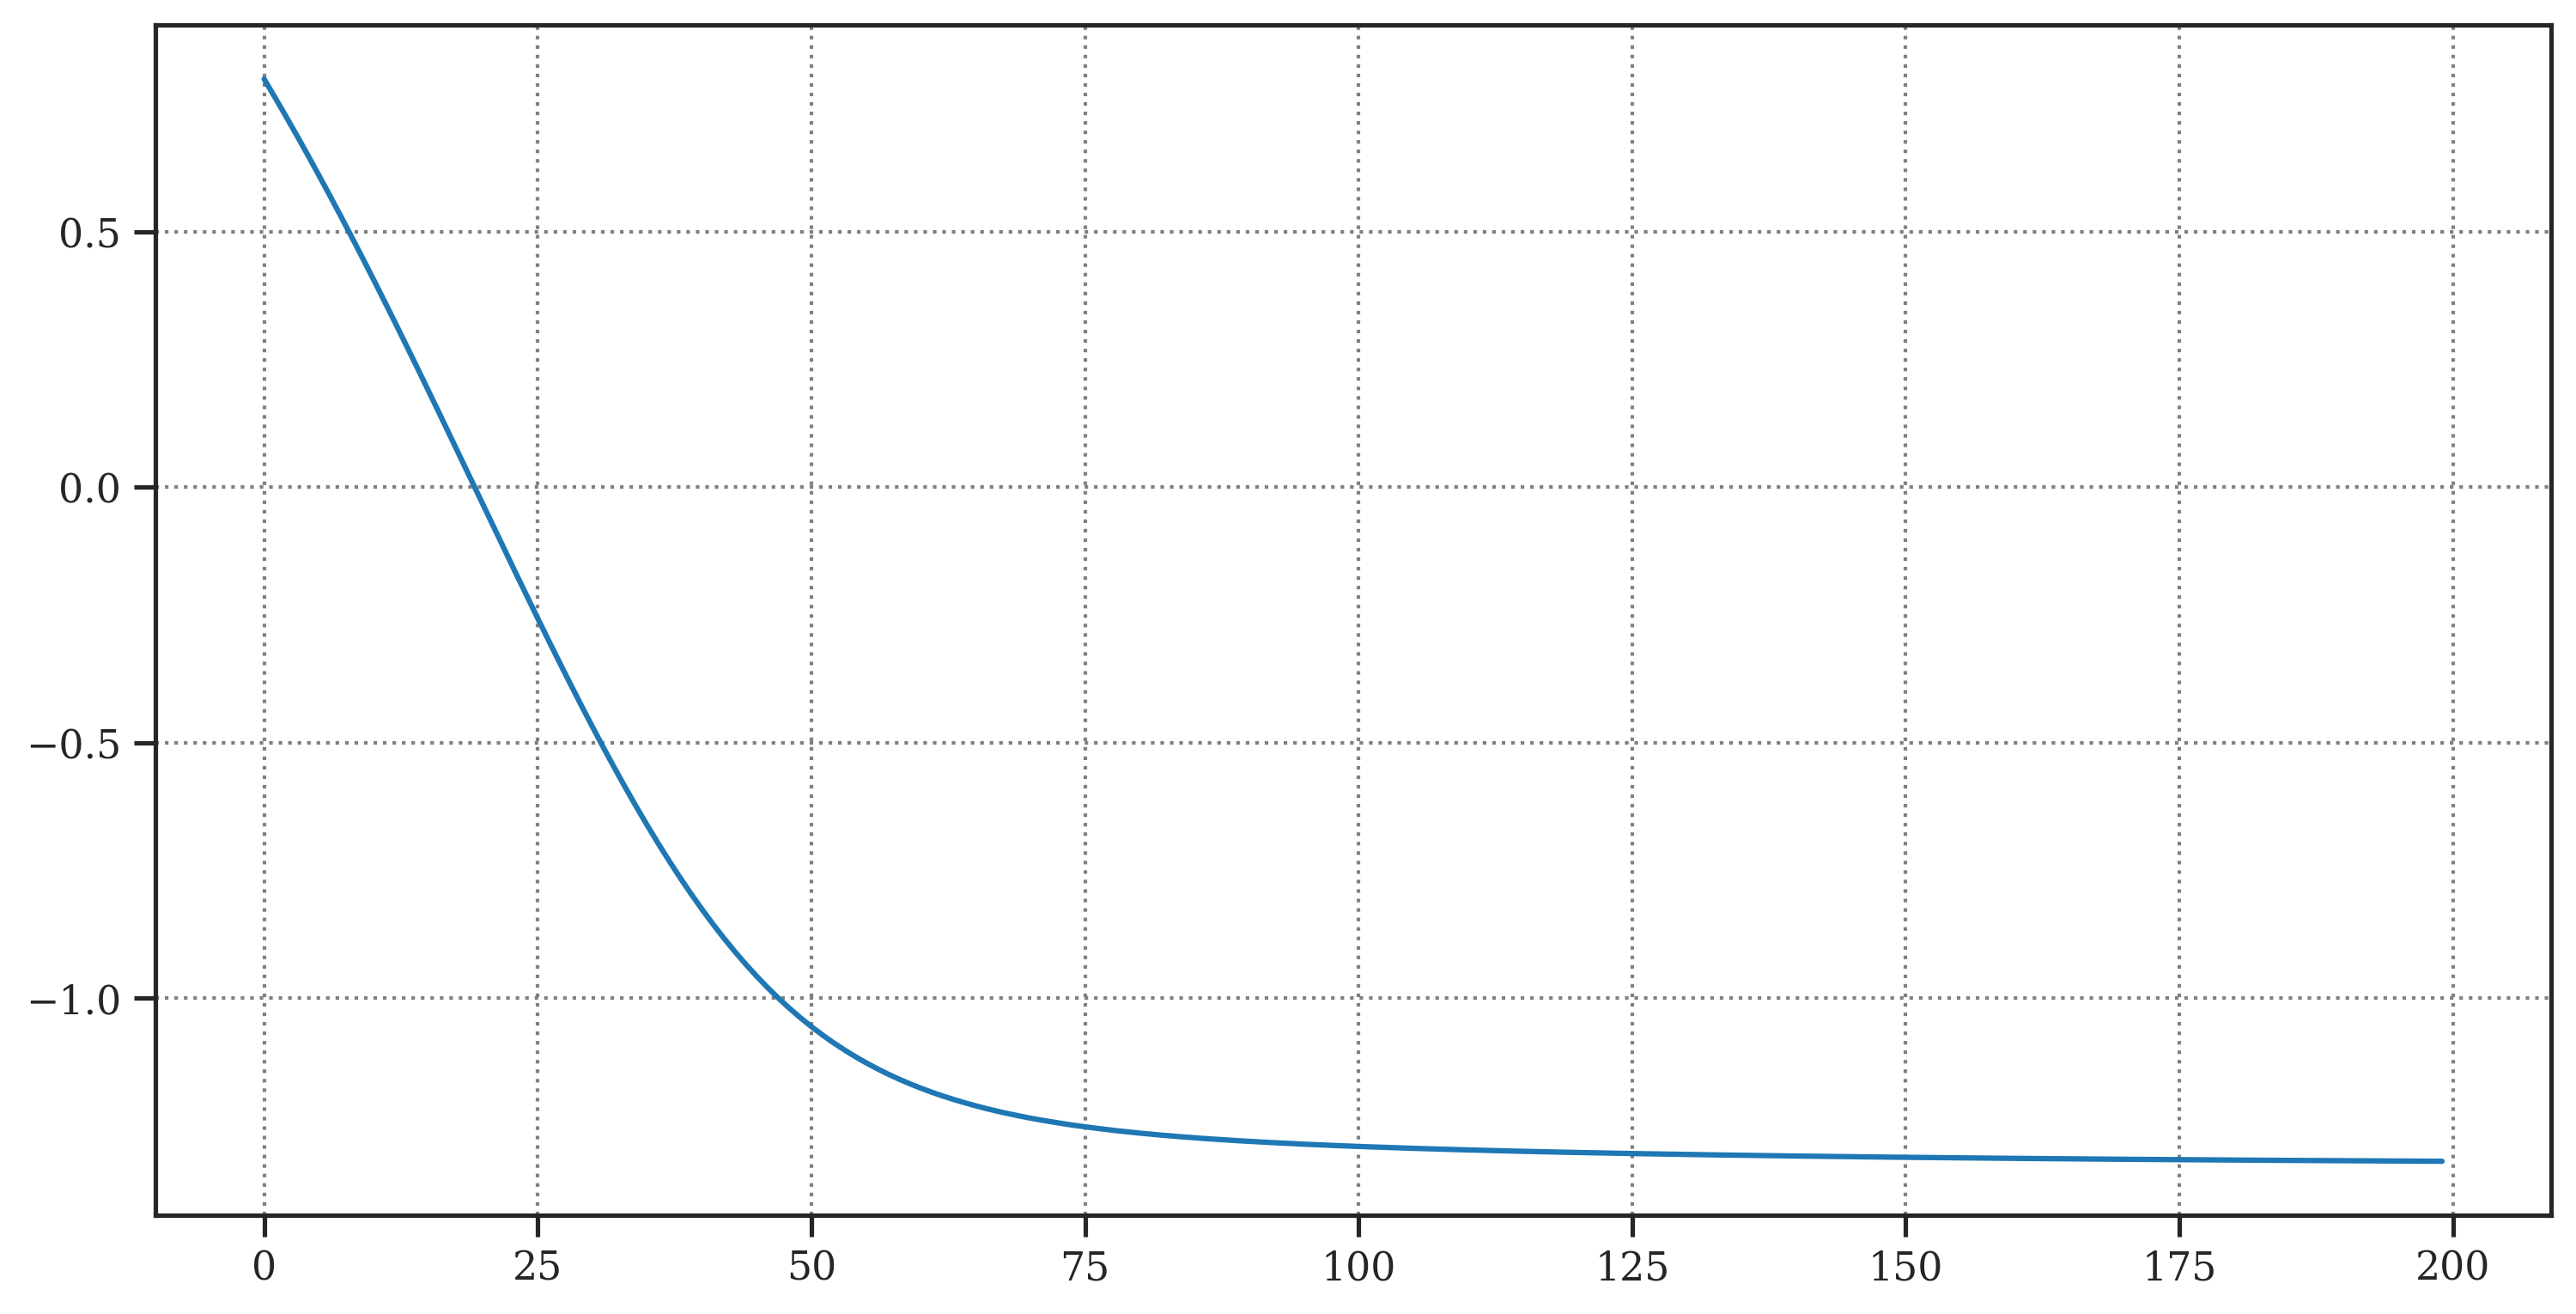

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

In [13]:
dt = 180

# Make predictions by feeding model through likelihood
x_test = torch.arange(x_tr.size(dim=0) + dt, dtype=torch.double)
if device.type == 'cuda':
    x_test = x_test.to(device)

model.eval()
likelihood.eval()

with torch.no_grad():
    observed = likelihood(model(x_test))
    y_mean = observed.mean
    lower, upper = observed.confidence_region()

In [14]:
if device.type == 'cuda':
    model = model.cpu()
    likelihood = likelihood.cpu()

    x_tr = x_tr.cpu()
    y_tr = y_tr.cpu()

    x_test = x_test.cpu()
    y_mean = y_mean.cpu()
    lower = lower.cpu()
    upper = upper.cpu()

The following plot shows the result of applying the smooth GP model to the observed time-series $b(t)$. The primary goal of the smooth GP model is to pre-process the noisy time-series $b(t)$ and have an estimate of the underlying oscillation. The model was initialized with a period of 90 minutes, based on previous observations of shallow cumulus cloud fields. We have tested a wide range of initial values of the oscillatory period, and the result is consistent regardless of the choice. The initial choice of 90-minute periodicity here is mainly to speed up the fitting process (as it is rather close to the end result) and to reflect observational evidence.

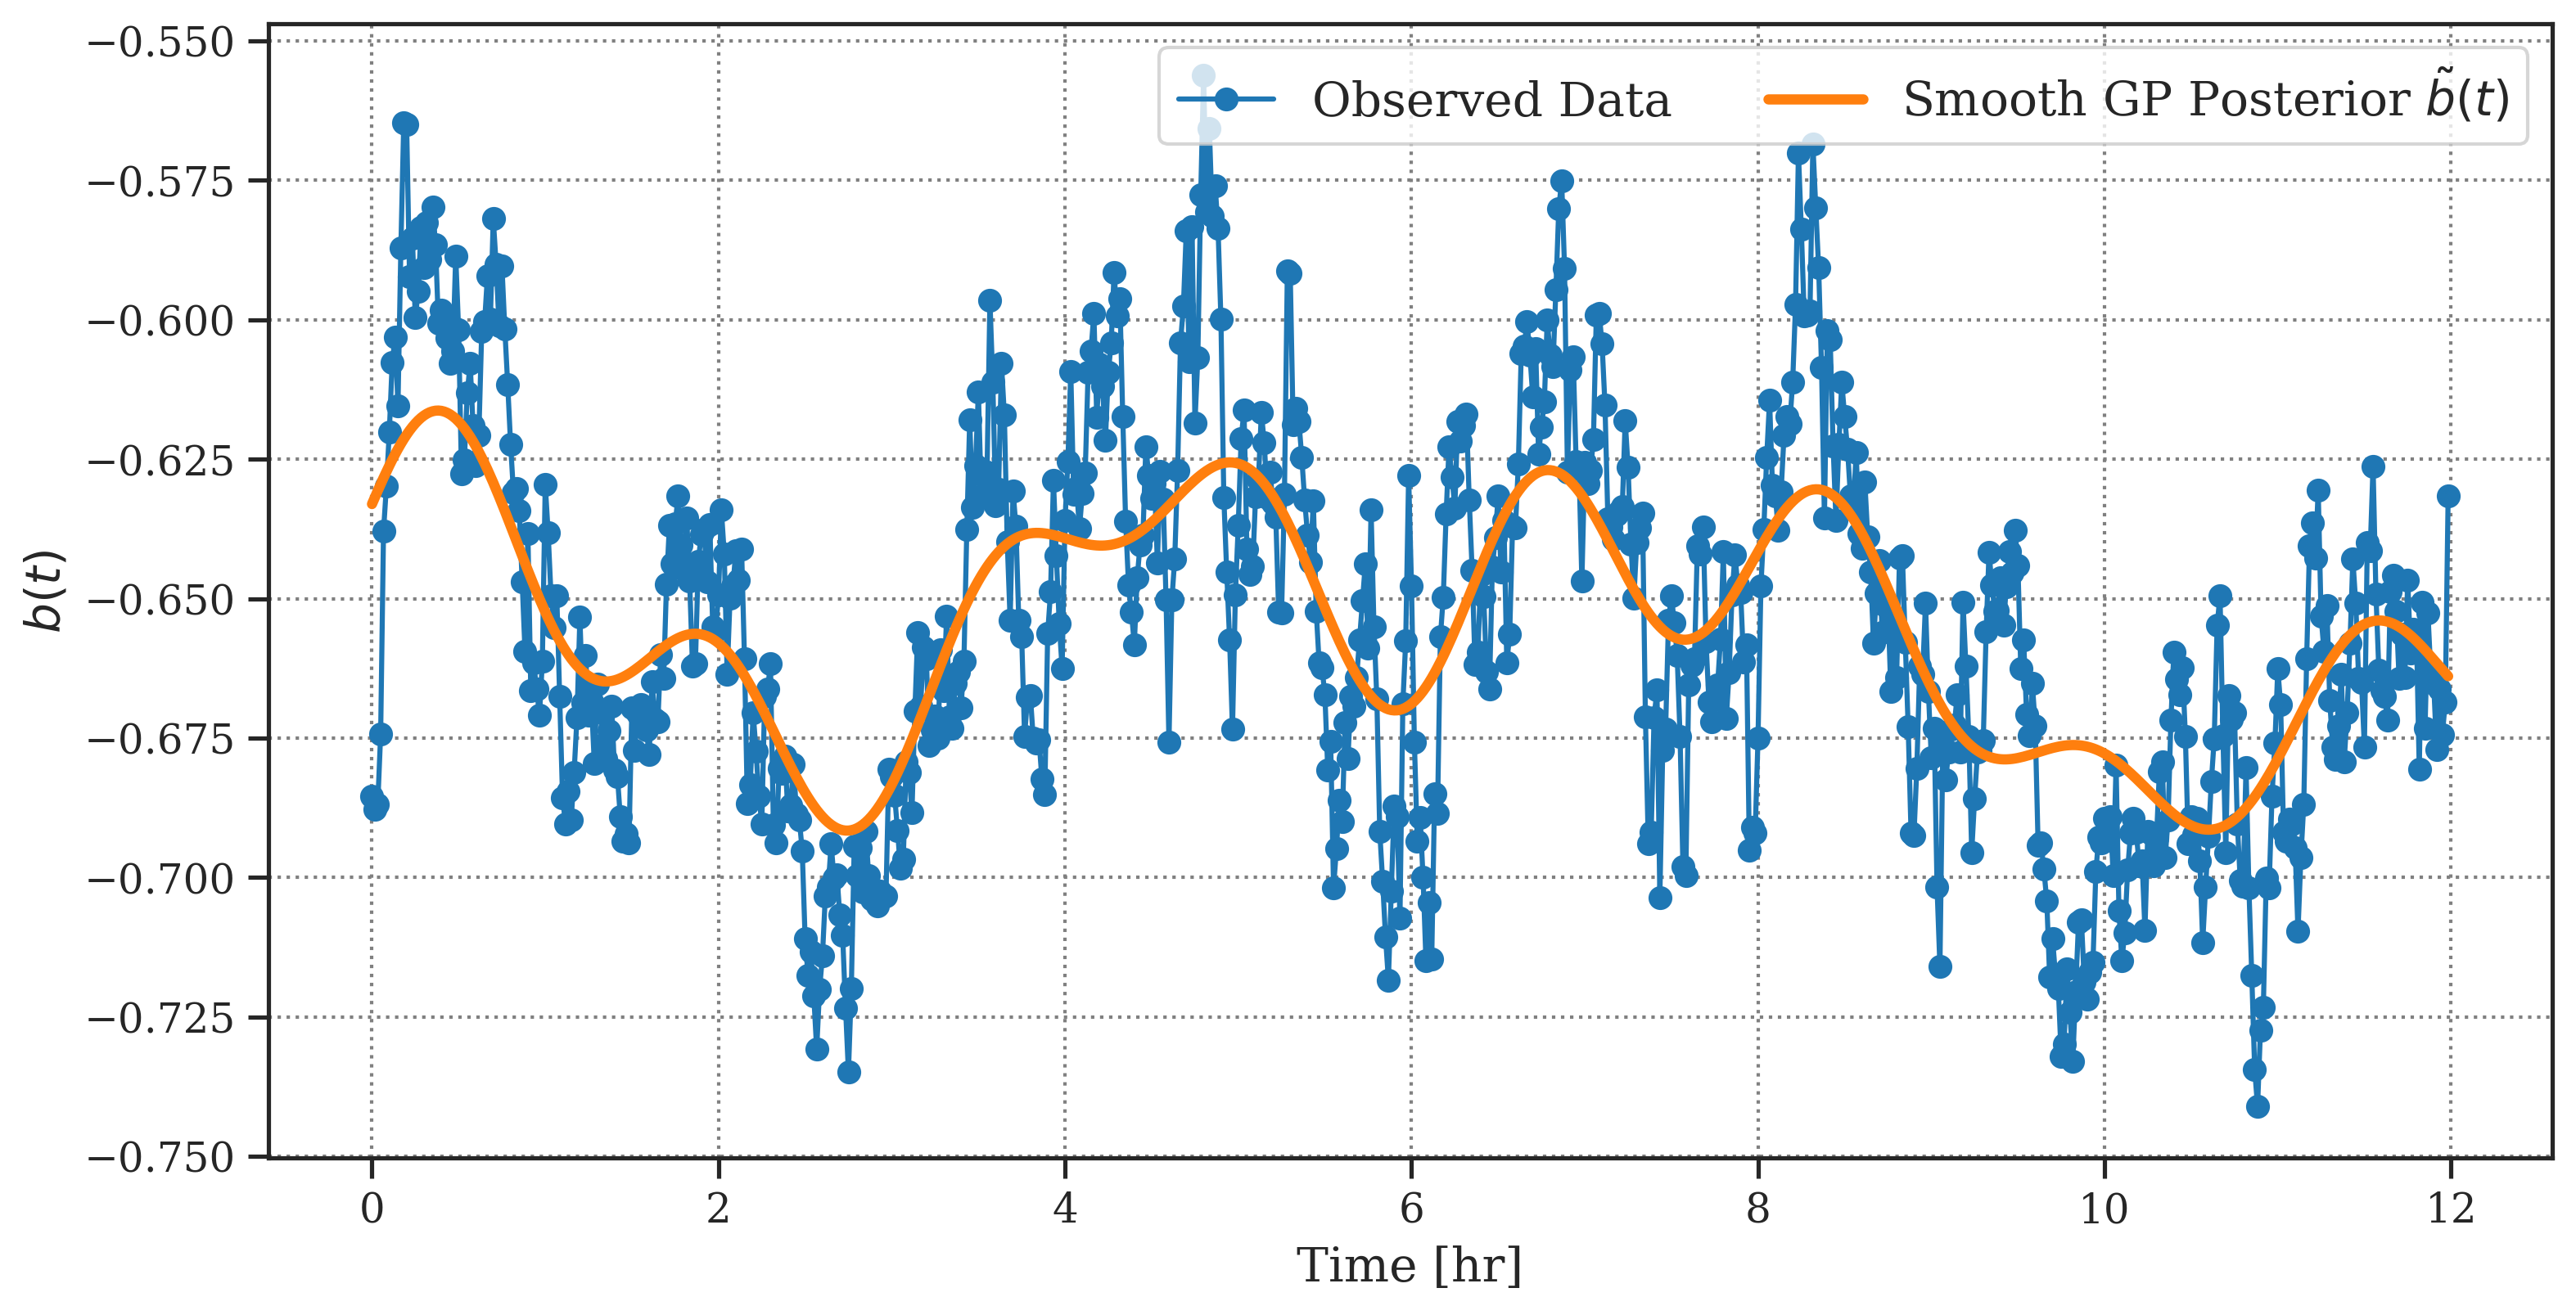

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)

ax.plot(x_full[:720] / 60, y_full[:720], 'o-', label="Observed Data")
ax.plot(x_test[:720] / 60, y_mean[:720], c=cp[1], lw=3, label="Smooth GP Posterior $\\tilde{b}(t)$")

ax.legend(fontsize=14, loc=1, ncol=2)

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("$b(t)$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

The smooth GP model $\tilde{b}(t)$ reports that the noisy time-series $b(t)$ consists of a 95-minute oscillation along with some variability, which is modelled by the SE kernel. The (non-oscillatory) changes in the observation likely comes from numerical uncertainties as well as small-scale variations within the cloud field, such as organization of clouds and changes in large-scale atmospheric properties.

The underlying time-series modelled by our GP model (orange line in the figure above) makes it more apparent that the slope $b$ of cloud size distribution $\mathcal{C}$ changes periodically, which confirms our hypothesis about the periodic evolution of the cloud field.

To further isolate the periodic component, we use the posterior distribution from the smooth GP model $\tilde{b}(t)$. It shows long-term, non-oscillatory trends (modelled by the SE kernel), which we will remove for the sake of isolating the oscillatory component from the noisy time-series. There are a few different ways to do this, and we chose to take the derivative of the time-series $b(t)$.

The derivative $\partial_t b(t)$ is shown below. It seems to oscillate around 0, which makes it easier to model the time-series with a periodic kernel. 


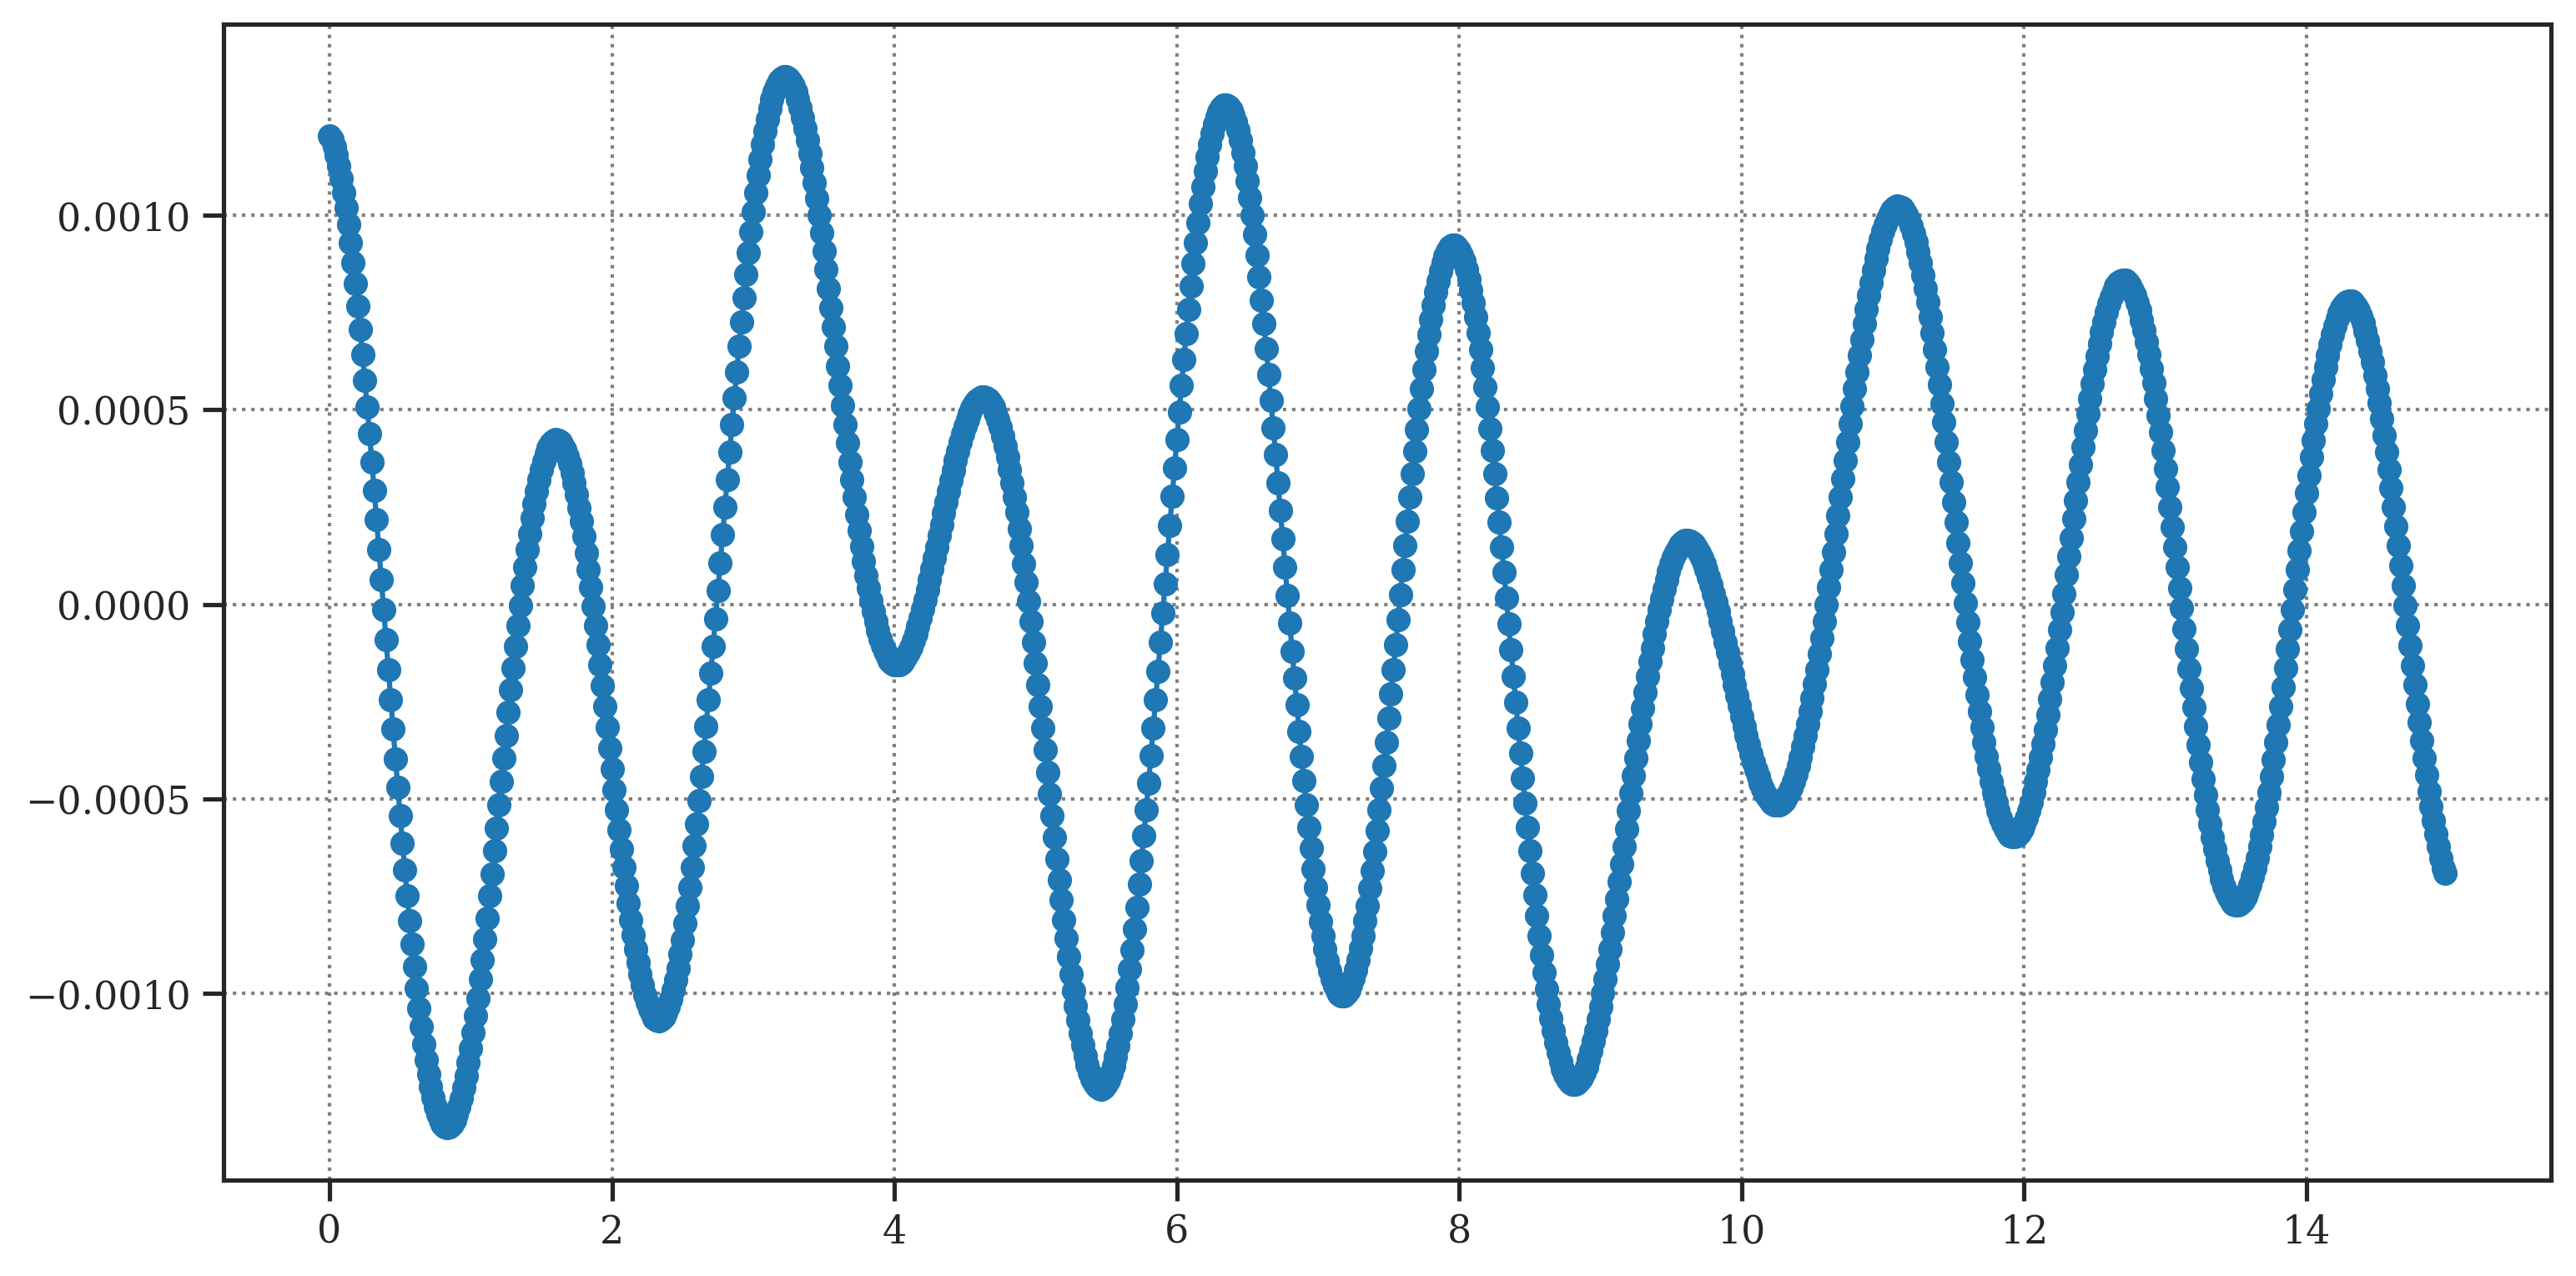

In [16]:
y_grad = np.gradient(y_mean)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_test / 60 , y_grad, 'o-')

## GP Regression with Periodic Kernel

Given the periodic portion of the observed time-series we have isolated in the previous section, we can more precisely determine the periodicity in the time-series by modelling the isolated time-series with a periodic GP model. For this purpose, we define a simple GP model with a periodic kernel, assuming that the isolated time-series is driven solely by periodic motions.

The following code defines our periodic GP model. It is initialized with a period of 90 minutes. We could use the 95-minute periodicity observed in the previous section, but we wanted to show that the model converges to the same periodic behaviour regardless.

In [17]:
x_tr = x_test.clone().detach().double()
y_tr = torch.tensor(y_grad, dtype=torch.double)

if device.type == 'cuda':
    x_tr = x_tr.to(device)
    y_tr = y_tr.to(device)

In [18]:
class PeriodicGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(PeriodicGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ZeroMean()
        
        self.cov_module = gpytorch.kernels.ScaleKernel(
            base_kernel = gpytorch.kernels.PeriodicKernel()
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)

        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov, validate_args=True)

In [19]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.Positive(),
    noise_prior = gpytorch.priors.NormalPrior(1e-4, 1e-2),
)
model = PeriodicGPModel(x_tr, y_tr, likelihood)

model.cov_module.base_kernel.initialize(
    period_length = torch.tensor(90.),
)

model.double()

PeriodicGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ZeroMean()
  (cov_module): ScaleKernel(
    (base_kernel): PeriodicKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_period_length_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [20]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:48} \t {param.item()}")
    
print(f"\n {model.cov_module.base_kernel}")

likelihood.noise_covar.raw_noise                         0.0

cov_module.raw_outputscale                               0.0

cov_module.base_kernel.raw_lengthscale                   0.0

cov_module.base_kernel.raw_period_length                 90.0

PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)

In [21]:
# Find optimal model hyperparameters
if device.type == 'cuda':
    model = model.to(device)
    likelihood = likelihood.to(device)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 600
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    period = model.cov_module.base_kernel.raw_period_length.item()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f} Period: {period:.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

600/600 Loss: -6.495 Period: 95.305: 100%|██████████| 600/600 [00:06<00:00, 97.29it/s] 


In [22]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:42} \t {param.item()}")

likelihood.noise_covar.raw_noise                 -15.855018848441995

cov_module.raw_outputscale                       -13.434634153434788

cov_module.base_kernel.raw_lengthscale           9.992318493901683

cov_module.base_kernel.raw_period_length         95.30967897437613

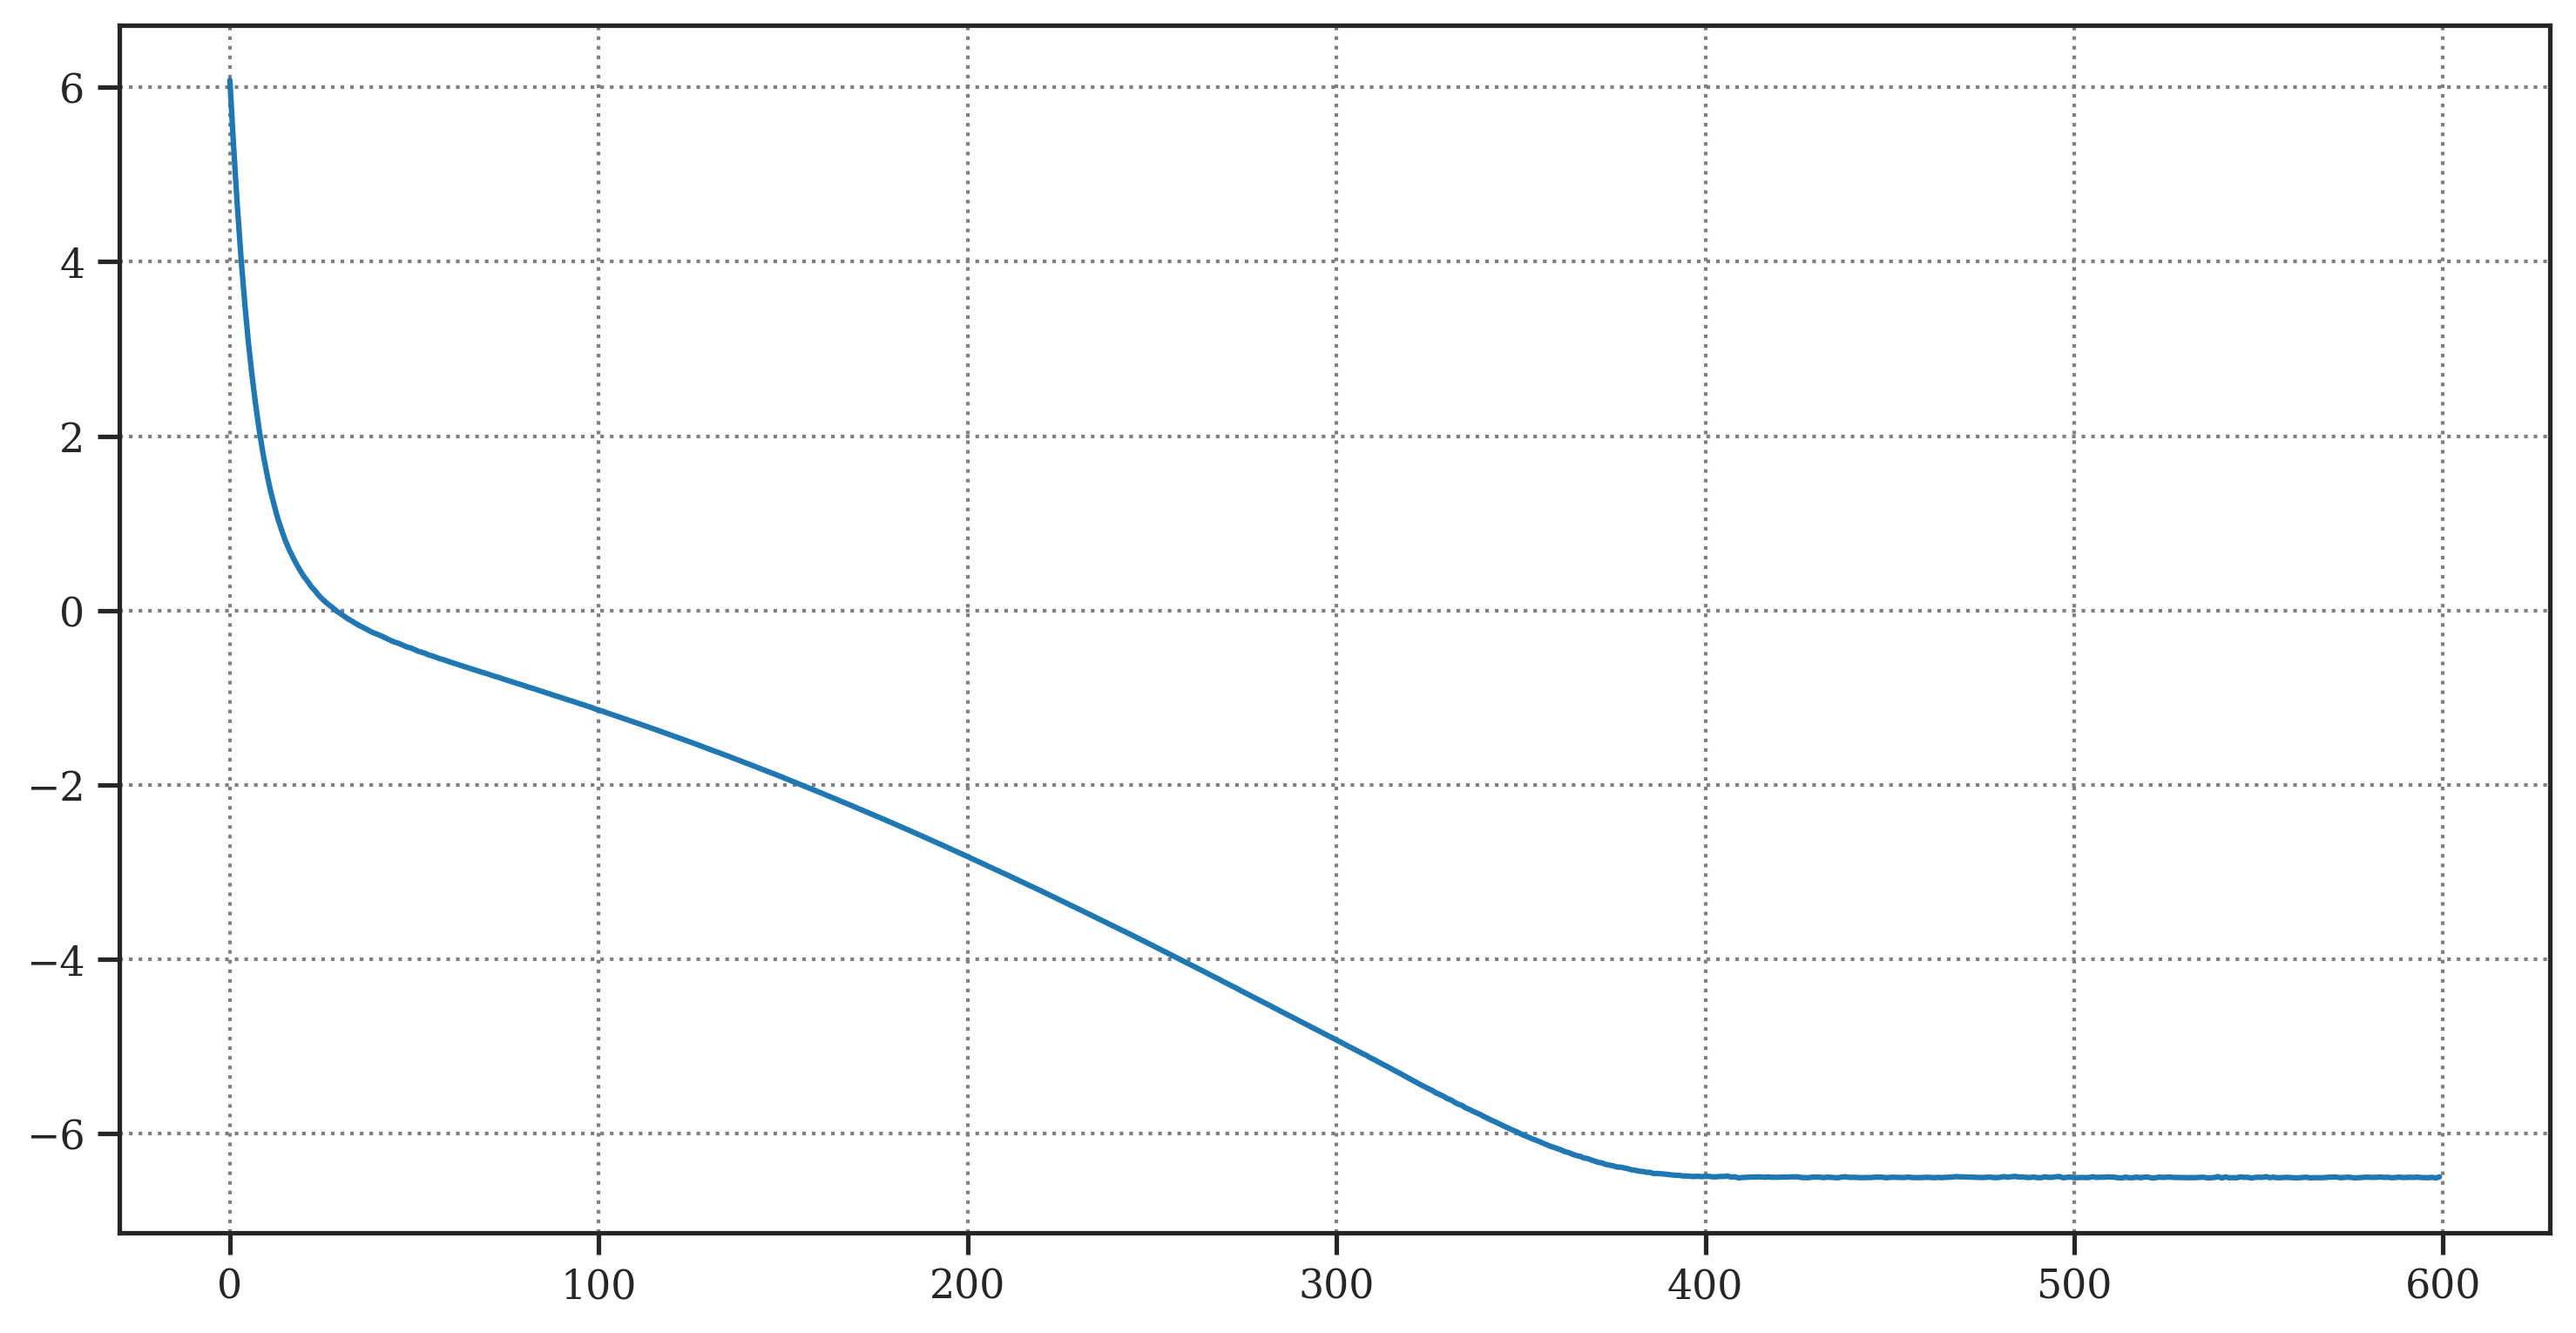

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

In [24]:
dt = 180

# Make predictions by feeding model through likelihood
x_test = torch.arange(x_tr.size(dim=0) + dt, dtype=torch.double)
if device.type == 'cuda':
    x_test = x_test.to(device)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed = likelihood(model(x_test))
    y_mean = observed.mean
    lower, upper = observed.confidence_region()

In [25]:
if device.type == "cuda":
    x_tr = x_tr.cpu()
    y_tr = y_tr.cpu()

    x_test = x_test.cpu()
    y_mean = y_mean.cpu()
    lower = lower.cpu()
    upper = upper.cpu()

In the figure below, we have taken 10 random samples from the posterior. The exact distribution of the samples will be slightly different every time this notebook is run, but all samples should display consistent periodic motions with roughly the same period.

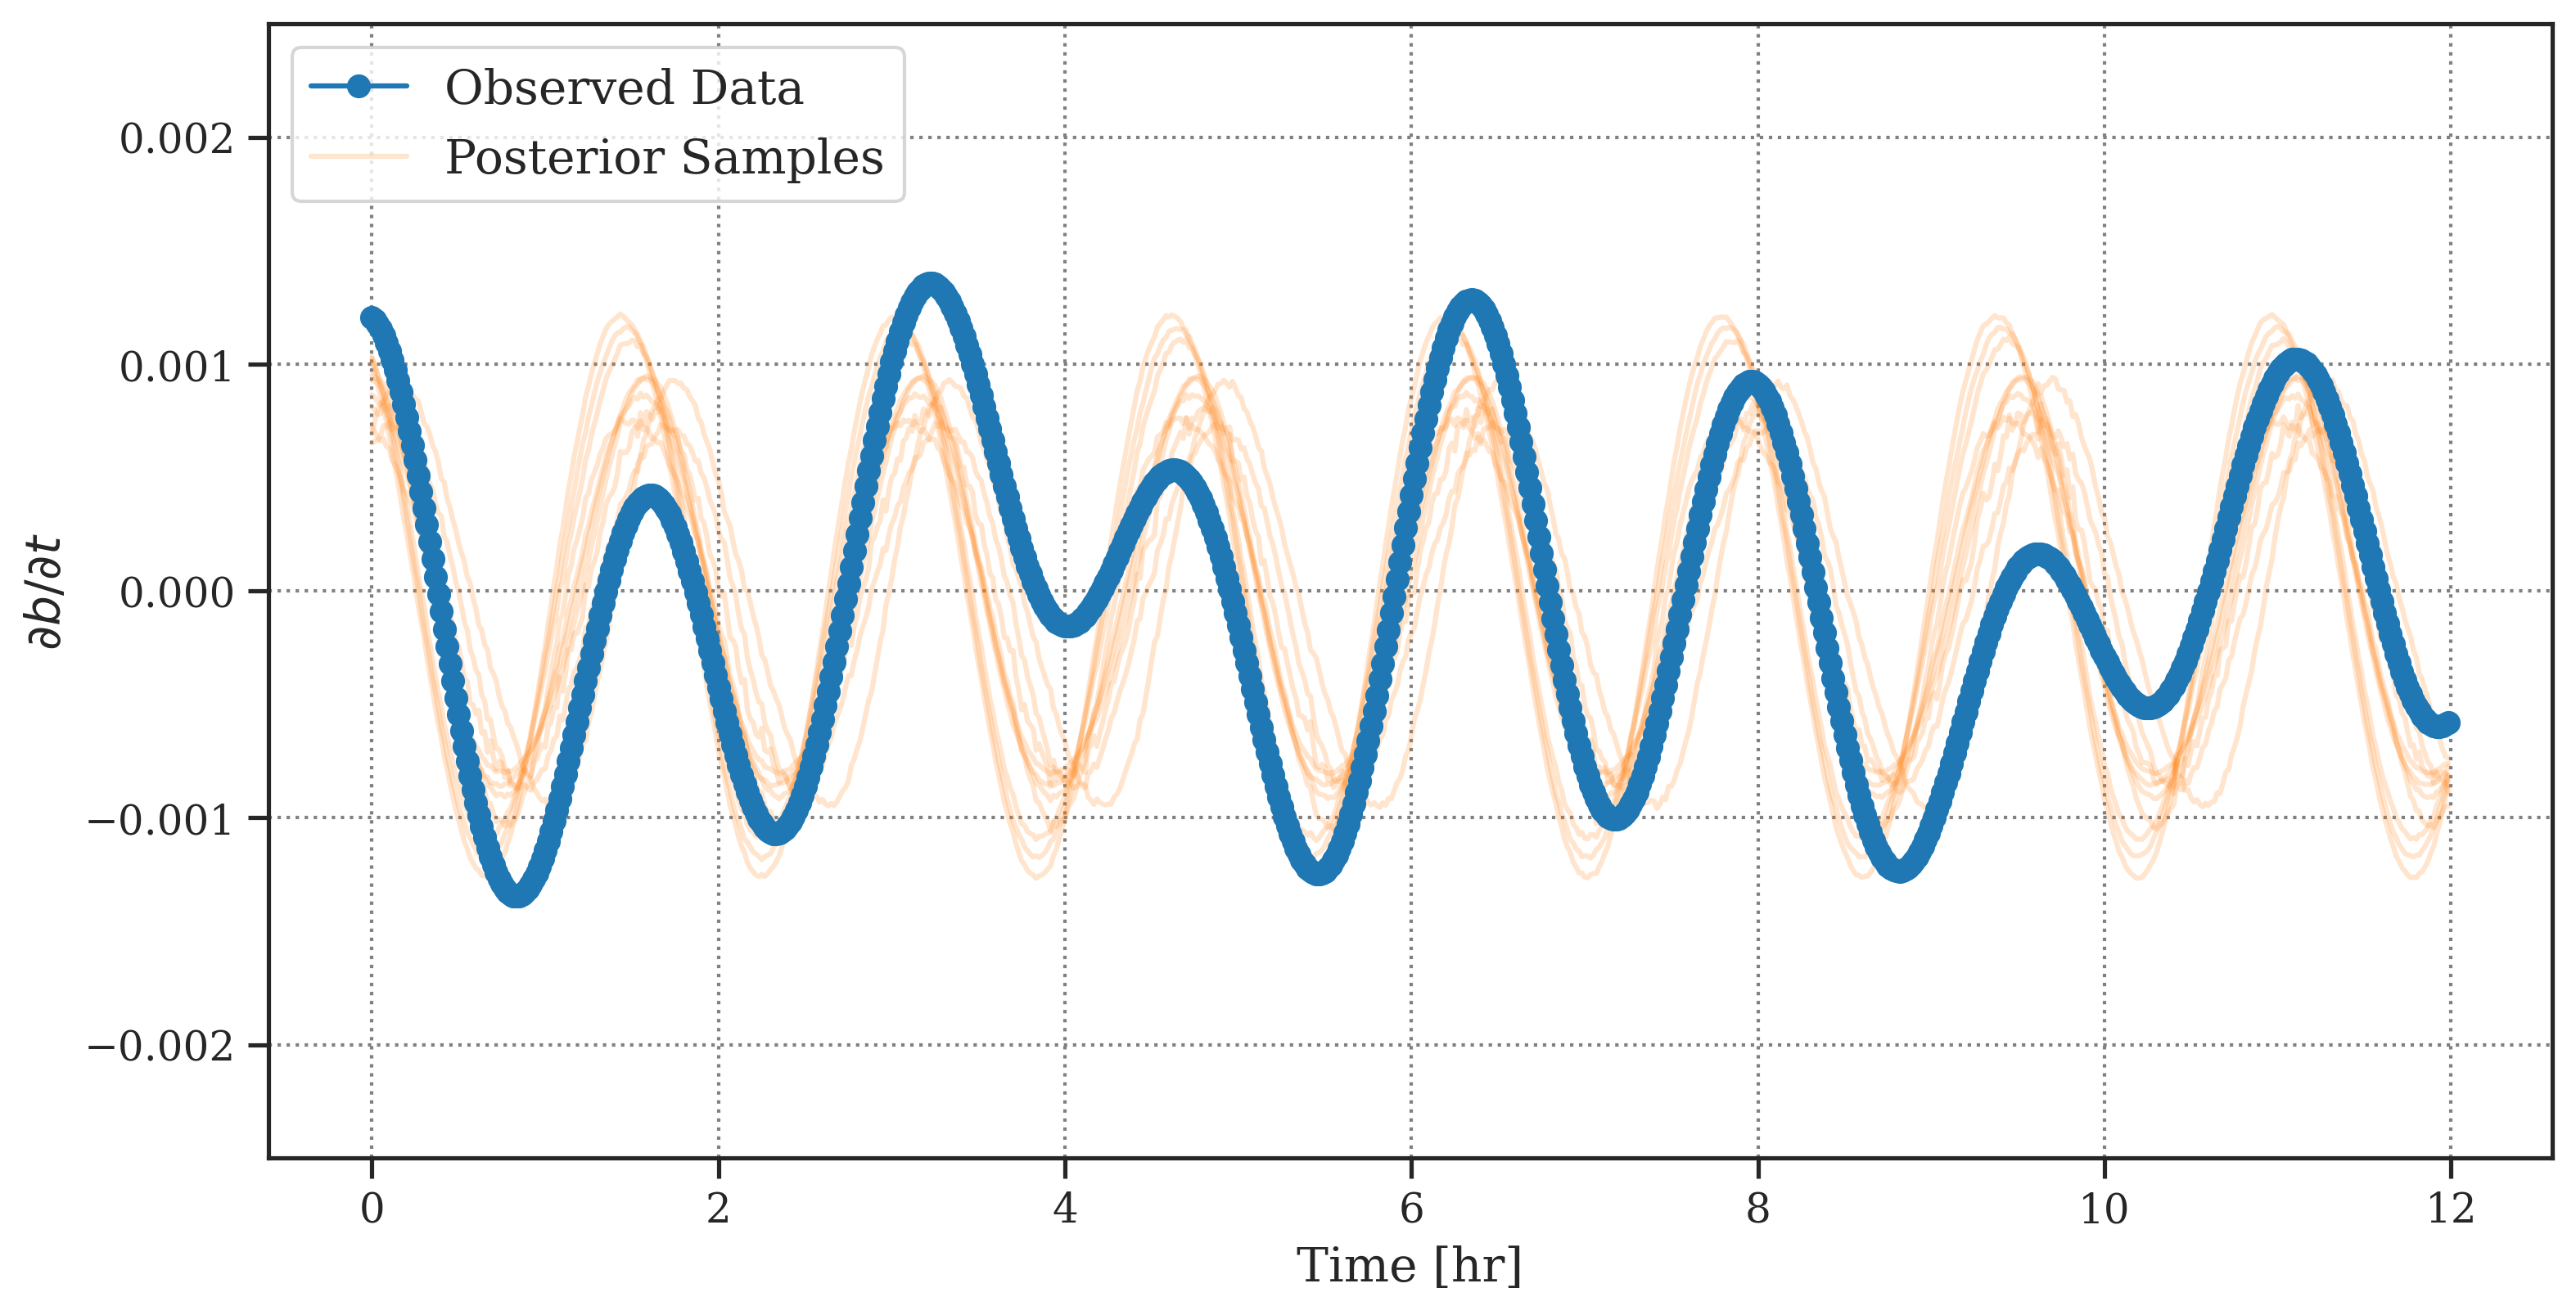

In [26]:
# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_tr[:720] / 60, y_tr[:720], "o-", c=cp[0], zorder=5)

for i in range(10):
    ax.plot(x_test[:720] / 60, observed.sample()[:720].cpu(), alpha=0.2, c=cp[1])

ax.legend(
    ["Observed Data", "Posterior Samples"],
    loc=2,
    fontsize=14,
)

ax.set_ylim([-2.5e-3, 2.5e-3])

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("$\partial b / \partial t$", fontsize=14)

ax.tick_params(axis="both", which="major", labelsize=12)


Then we take the mean of all samples to obtain the (mean) posterior distribution as well as a 95% confidence interval. Again, the exact shape of the posterior distribution will be slightly different if the notebook has been re-run, but the time-series $\partial b(t)$ should be very close to the posterior distribution (except with small non-oscillatory variations) and fall within the proposed confidence interval.

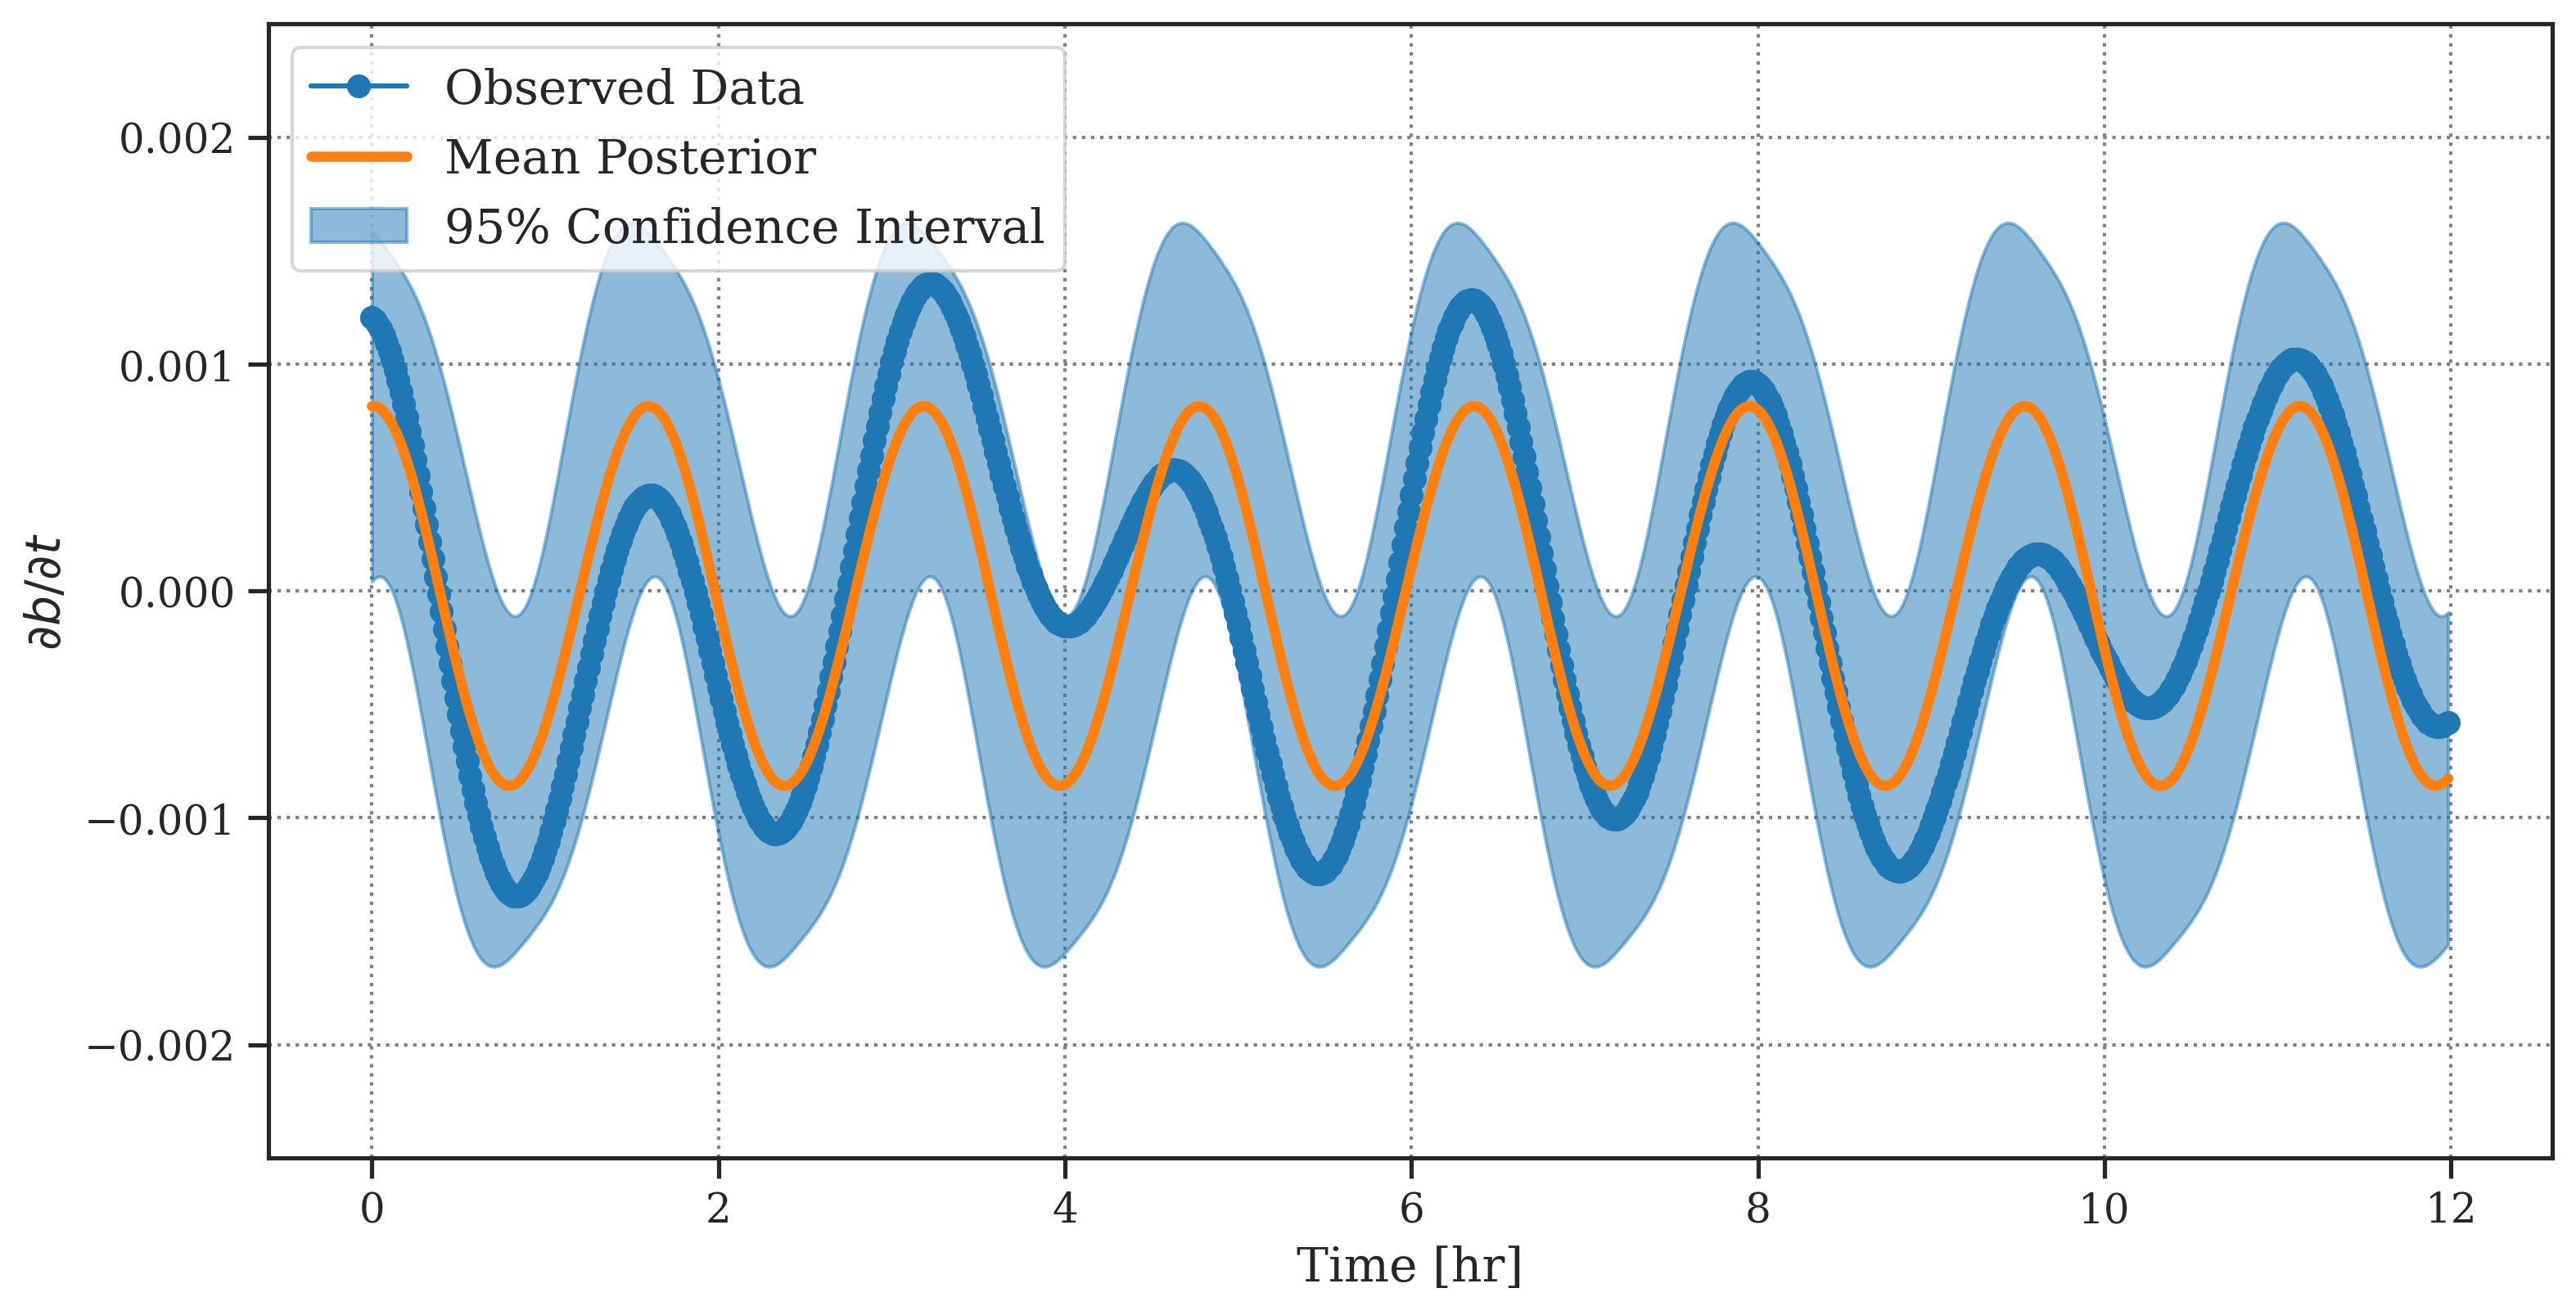

In [27]:
# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_tr[:720] / 60, y_tr[:720], "o-", c=cp[0])
ax.plot(x_test[:720] / 60, y_mean[:720], c=cp[1], lw=3)
ax.fill_between(x_test[:720] / 60, lower[:720], upper[:720], alpha=0.5, color=cp[0])

ax.legend(
    ["Observed Data", "Mean Posterior", "95% Confidence Interval"],
    loc=2,
    fontsize=14,
)

ax.set_ylim([-2.5e-3, 2.5e-3])

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("$\partial b / \partial t$", fontsize=14)

ax.tick_params(axis="both", which="major", labelsize=12)


Finally, we can see how the 95-minute oscillation appears in comparison to the observed time-series $b(t)$ by integrating the posterior distribution above and normalizing the two distributions. The following code uses locally weighted scatterplot smoothing (LWESS) method to perform local regression on the noisy time-series $b(t)$ and plots the integrgal of $\partial b(t)$ to represent the underlying 95-minute oscillation.

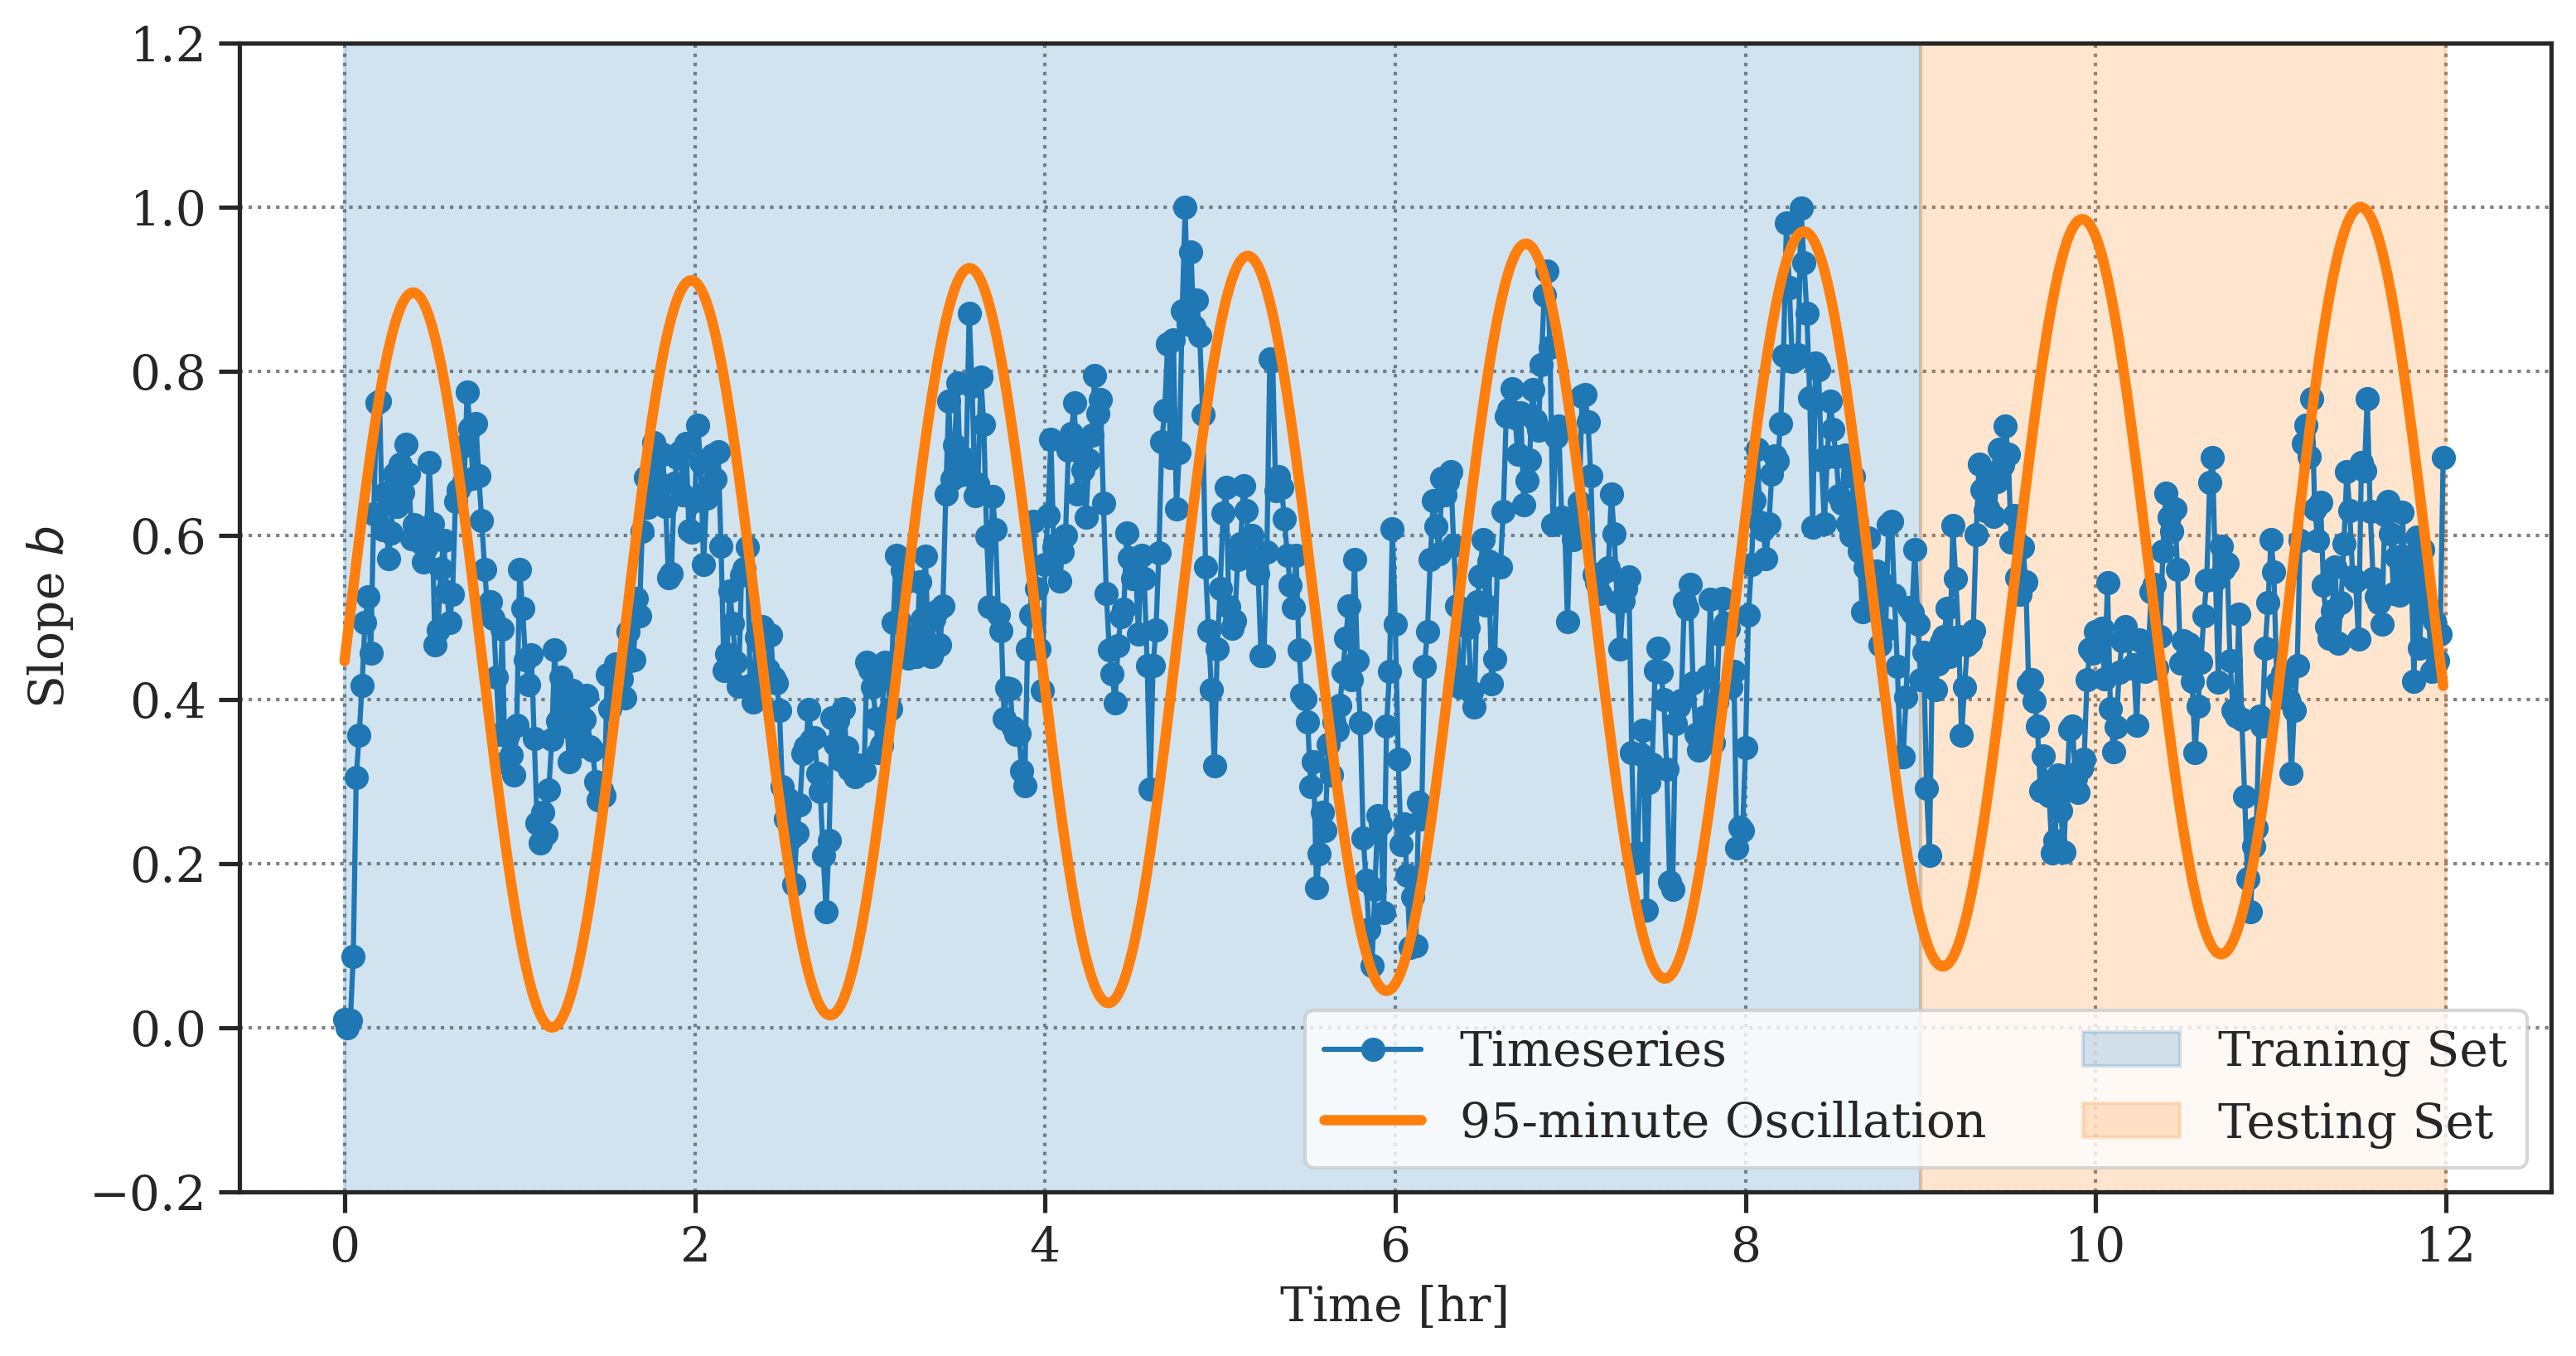

In [28]:
y_pr = y_mean.numpy()[:720]
y_pr = np.cumsum(y_pr - np.mean(y_pr, axis=0))

y_sl = y_full[:720] - sl.lowess(y_full[:720], x_full[:720], return_sorted=False, frac=0.3)

x_c = np.arange(len(y_pr)) / 60

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_c,
    skl_prep.minmax_scale(y_sl[:, None], axis=0),
    "o-",
    c=cp[0],
    label="Timeseries")
ax.plot(
    x_c,
    skl_prep.minmax_scale(y_pr[:, None], axis=0),
    "-",
    c=cp[1],
    lw=3,
    label="95-minute Oscillation",
)

ax.axvspan(0, 9, alpha=0.2, color=cp[0], label="Traning Set")
ax.axvspan(9, 12, alpha=0.2, color=cp[1], label="Testing Set")

ax.legend(loc=0, ncol=2, frameon=True, fontsize=14)

ax.set_ylim([-0.2, 1.2])

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis="both", which="major", labelsize=14)